In [1]:
!pip install opencv-python-headless==3.4.9.31
!pip install keras-tqdm
!pip install pyspellchecker 
!pip install gTTS
import cv2
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 21.6MB 1.5MB/s 
     |████████████████████████████████| 1.9MB 12.3MB/s 


Original Image


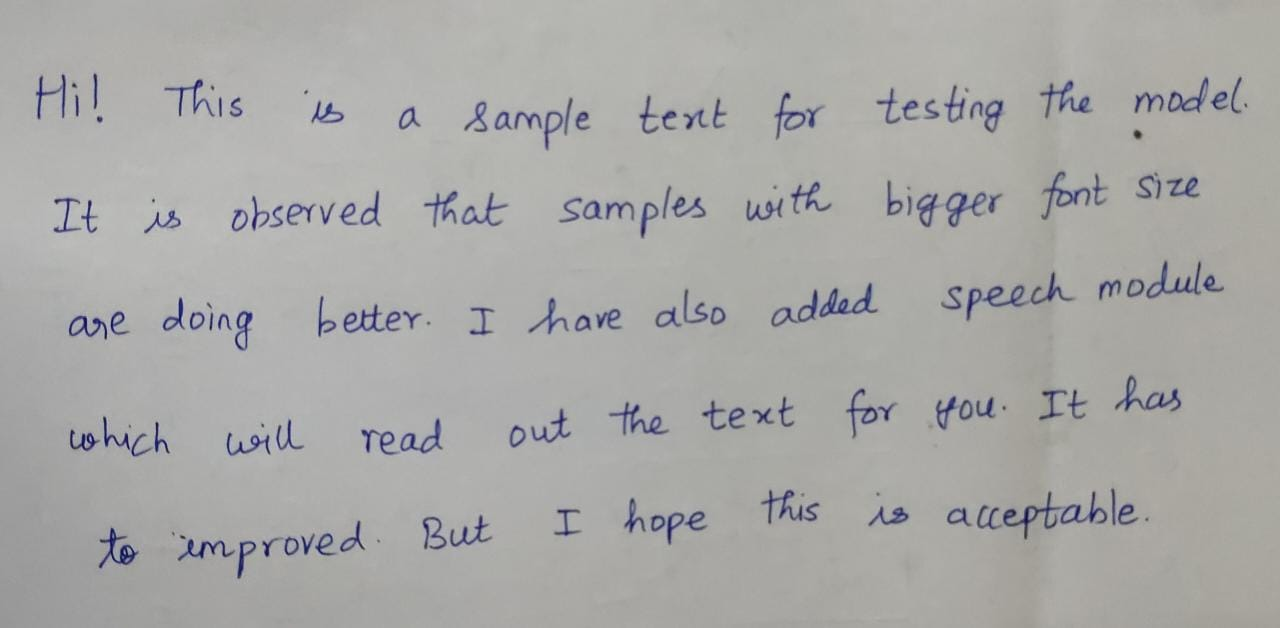

In [2]:
#import and show image
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/common_modules/test images/im1.jpeg')
print('Original Image')
cv2_imshow(image)

In [3]:
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
#print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.config.experimental.list_physical_devices('GPU')

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

#print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

In [5]:
#MODEL

# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [6]:
#LOAD WEIGHTS
act_model.load_weights('/content/drive/MyDrive/Colab Notebooks/common_modules/adamo-100000r-30e-77006t-8557v.hdf5')

In [7]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
   # img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [8]:
def pred(img):
  pxmin = np.min(img)
  pxmax = np.max(img)
  imgContrast = (img - pxmin) / (pxmax - pxmin) * 255
  wi=''
  worda=[]
# increase line width
  kernel = np.ones((3, 3), np.uint8)
  imgMorph = cv2.erode(imgContrast, kernel, iterations = 1)
  p=process_image(imgMorph)
  p=p.reshape((1,32,128,1))
  prediction = act_model.predict(p)
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  for x in out:
   # print("original_text =  ", valid_original_text[i])
    #print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
           worda.append(char_list[int(p)])   
    wi=wi.join(worda)   
  return wi

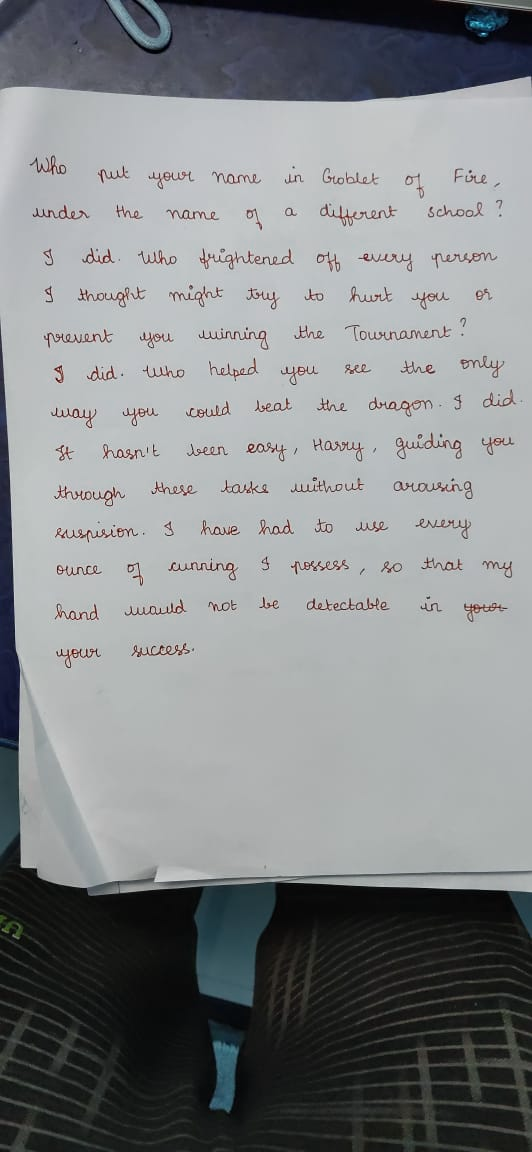

In [9]:

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/common_modules')
a=[]
import page
import words
from PIL import Image
import cv2

# User input page image 
image = cv2.cvtColor(cv2.imread("/content/drive/MyDrive/Colab Notebooks/common_modules/test images/im5.jpeg"), cv2.COLOR_BGR2RGB)
cv2_imshow(image)
speech=[]




In [ ]:
# Crop image and get bounding boxes
#crop = page.detection(image)
io=image.copy()
boxes = words.detection(io)
lines = words.sort_words(boxes)

# Saving the bounded words from the page image in sorted way
i = 0
for line in lines:
    text = io.copy()
    for (x1, y1, x2, y2) in line:
        roi = text[y1:y2, x1:x2]
        # save = Image.fromarray(text[y1:y2, x1:x2])
        # print(i)
        a.append(roi)
        #.save("segmented/segment" + str(i) + ".png")
        i += 1

for i in range(len(a)):
  img=a[i]
  #print('Actual word')

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  # print(gray.shape)
  t=pred(gray)
  #print("Predicted Text: ",t)
  #cv2_imshow(gray)
  speech.append(t)
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(speech)
for i in range(len(speech)):
  if speech[i].lower() in misspelled:
    speech[i]=spell.correction(speech[i])

 
  


In [11]:

from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
separator = ' '
stri=separator.join(speech)
tts = gTTS(stri) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
#Audio(sound_file, autoplay=True) 

In [12]:
stri

'wr wo out san made sn asks surges under the mams " a seen I sad was rerorunes on any prom \' shags sy to Tavnemses nod # . foh pent have many th th ras : did over th to wagon : sway sys sod mypisaasge gelding yo so now was taw song strange thos had so very suppose I ta I as # ? even prsessreos is sas my hand sums so to deare # ynys was , . . & b sad A'

In [13]:
Audio(sound_file, autoplay=True) 